# metaL: <u>meta L</u>anguage

## homoiconic graph metaprogramming system

(c) Dmitry Ponyatov <<dponyatov@gmail.com>>

* concept metaprogramming
* software transformation
* model driven design

In [80]:
# ! pip install -U pip
# ! pip install -U ply graphviz

# Core

In [81]:
import os,sys
from graphviz import Digraph

# plot visualizations for this Jupyter notebook
viz = Digraph()

## Frame

Root object class, implemented on ideas of a book: \[[PDF](https://courses.media.mit.edu/2004spring/mas966/Minsky%201974%20Framework%20for%20knowledge.pdf)\] \
Marvin Minsky **A Framework for Representing Knowledge** 1974

The *frame model* was **extended** to support ordered storage is definitely required for representing 
* *attribute grammar* widely known in programming languages design, and 
* *ordered data storages* itself.

The presence of an ordered collection is definitively required for representing any program source code, as this is very close to classical attribute grammar -- attributed trees and graphs. The frame (object) graph representation of a program as an executable form is much more effective and native for any work involved with source code transformations: synthesis, modifications, analysis, cross-language translation, etc.

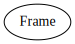

In [82]:
viz.node('Frame') ; viz

### Frame is a universal knowledge representation

The hypothesis: **directed hypergraph is a universal knowledge representation** that can describe anything including software specifications, programs, data and documentation in the same universal form. As we use the *same structure for program and data* representation, and this structure can be executed by interpretation, we have a **homoiconic metaprogramming system**.

### EDS: <u>E</u>xecutable <u>D</u>ata <u>S</u>tructure method

In software design in a case when our programming language or computing platform does not provide some features, we can add a layer of interpretation for some data structure to get more dynamics or extra features such as metaprogramming, program self-modification, compact low memory bytecode, etc. For example, in the Lisp language, all programs are represented in the form of executable lists. Java uses bytecode as the main program form, which does not require, but often uses JIT for runtime compilation as a way to make the program run faster.

The `metaL` system uses attributed hypergraph as an executable data structure:
* every hypergraph **frame defines N-ary relations between operands** in `nest[]` and named attributes in `slot{}`s the way close to Prolog predicates
* **frames are typed** so every frame class can describe different behavior and properties of a frame
* the graph has the advantage to be not visual but **visualizable language**, which can be used for imperative, declarative, dataflow (and maybe functional?) **multiparadigm** programming

In [83]:
## Marvin Minsky's extended frame model

class Frame:
    
    ## [token] constructor
    
    def __init__(self,V):
        # type/class tag /required for lexer using PLY library/
        self.type = self.__class__.__name__.lower()
        # scalar value: symbol name, string, number
        self.val  = V
        # slots = attributes = vocabulary
        self.slot = {}
        # AST nested = universal ordered container = stack
        self.nest = []

In [84]:
Frame('Hello World')

### Tree dump / to plain text /

We'll use **tree dump** as an easy to use method to see any frame graph in a text form.

In [85]:
class Frame(Frame):
    
    ## dump
    
    # print/str conversion
    def __repr__(self):
        return self.dump()
    
    # full tree dump
    def dump(self,depth=0,prefix=''):
        # subtree header
        tree = self._pad(depth) + self.head(prefix)
        # infty recursion block
        if not depth: Frame._dump = []
        if self in Frame._dump: return tree + ' _/'
        else: Frame._dump.append(self)
        # slot{}s
        for i in self.slot:
            tree += self.slot[i].dump(depth+1,'%s = '%i)
        # nest[]ed
        idx = 0
        for j in self.nest:
            tree += j.dump(depth+1,'%i: '%idx) ; idx +=1
        # resulting subtree
        return tree
    
    # short <T:V> header-only dump
    def head(self,prefix=''):
        return '%s<%s:%s> @%x' % (prefix,self.type,self._val(),id(self))
    # tree dump padding
    def _pad(self,depth):
        return '\n' + '\t' * depth
    # .val in dump must be overridable for strings, numbers,..
    def _val(self):
        return '%s' % self.val

In [86]:
print(Frame('Hello World').dump(prefix='prefix = '))


prefix = <frame:Hello World> @7f7c7806f390


**`<T:V>` header** contains
* `T` type/*class tag*
* `V` scalar *value*
* optional `prefix` used for *slot names printing in tree dump*
* `idx` counter shows index of every element in the universal ordered container *mostly used as a stack*
* `@hex` a pointer is unique for every object in a system lets to *distinct objects with the same `T:V` pair*

### Graph plot

As we pretend to make not visual but **visualizable programming language**, we must have a graph plotting tool to see any part of an EDS program graph as a diagram.

In [87]:
class Frame(Frame):
    
    ## plot
    
    # recursive traversal with graphviz calls
    def plot(self,dot=None,parent=None,link='',color='black'):
        if not dot: # init
            dot = Digraph(graph_attr={'rankdir':'LR'})
            Frame._plot = []
        # plot node and optional edge from parent / like header in .dump() /
        dot.node('%s'%id(self),label='%s:%s'%(self.type,self._val())) # ref via id()
        if parent: dot.edge('%s'%id(parent),'%s'%id(self),label='%s'%link,color=color)
        # rings/infty recursion block
        if self in Frame._plot: return dot
        else: Frame._plot.append(self)
        # slot{}s with blue edges and slot names
        for i in self.slot: dot = self.slot[i].plot(dot,parent=self,link=i,color='blue')
        # nest[]ed with green edges and integer indexes
        idx = 0
        for j in self.nest: dot = j.plot(dot,parent=self,link=idx,color='green') ; idx += 1
        # return resulting plot
        return dot

### Operators

To manipulate frames in a pythonic way we need to define some rarely used operators to do frame combinations:

In [88]:
class Frame(Frame):
    
    ## operators

    # ` A[key] get ` frame by slot name
    def __getitem__(self,key):
        return self.slot[key]
    
    # ` A[key] = B ` set/create slot with name and frame
    def __setitem__(self,key,that):
        if isinstance(that,Frame): self.slot[key] = that
        elif isinstance(that,str): self.slot[key] = String(that)
        elif isinstance(that,int): self.slot[key] = Integer(that)
        else: raise TypeError([type(that),that])
        return self
    
    # ` A << B ` set slot with A[B.val] = B
    def __lshift__(self,that):
        if isinstance(that,Frame): self[that.val] = that
        else: raise TypeError([type(that),that])
        return self
    
    # ` A // B ` push to nest[]ed
    def __floordiv__(self,that):
        if isinstance(that,Frame): self.nest.append(that)
        elif isinstance(that,str): self.nest.append(String(that))
        elif isinstance(that,int): self.nest.append(Integer(that))
        else: raise TypeError([type(that),that])
        return self

    # ` A + B ` add
    def __add__(self,that):
        if isinstance(that,str): return String(self.val + that)
        else: raise TypeError([type(that),that])
        return self


# Primitives

In [89]:
## Primitives

class Primitive(Frame): pass

class Symbol(Primitive): pass

class String(Primitive):
    def _val(self,maxlen=55):
        s = ''
        l = 0
        for c in self.val:
            if l < maxlen:
                l += 1
                if   c == '\n': s += r'\n'
                elif c == '\t': s += r'\t'
                else:           s += c
        return s

class Number(Primitive): pass
class Integer(Number): pass


<frame:Hello> @7f7c70283eb8
	some = <frame:attribute> @7f7c70283128
		slot = <frame:slot> @7f7c70279860
	self = <frame:Hello> @7f7c70283eb8 _/
	string = <string:typecasted> @7f7c702799b0
	0: <frame:World> @7f7c70283ba8
	1: <frame:Hello> @7f7c70283eb8 _/
	2: <string:string> @7f7c702836a0


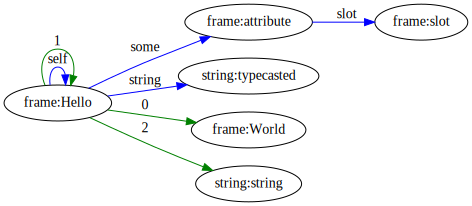

In [90]:
hello = Frame('Hello') // Frame('World')
hello['some'] = Frame('attribute') << Frame('slot')
hello['self'] = hello // hello # self ring
hello['string'] = 'typecasted' ; hello // 'string'
print(hello)
hello.plot()


## EDS: Executable Data Structure class subset

In [91]:
## EDS: Executable Data Structure

class Active(Frame): pass

### VM commands wraps Python functions

In [92]:
class Cmd(Active): pass

### Global Virtual Machine

In [93]:
class VM(Active): pass

In [94]:
vm = VM('metaL') ; vm['vm'] = vm

# Metaprogramming

In [95]:
## metaprogramming

class Meta(Frame): pass
class Module(Meta): pass


vm['MODULE'] = Module(os.path.split(sys.argv[0])[-1][:-3])
print(vm)


<vm:metaL> @7f7c70283f60
	MODULE = <module:ipykernel_launcher> @7f7c7028dd30
	vm = <vm:metaL> @7f7c70283f60 _/


# IO

In [96]:
## IO

class IO(Frame): pass
class Dir(IO): pass
class File(IO): pass

## Network

In [97]:
## network

class Net(IO): pass
class IP(Net): pass
class Port(Net): pass
class Web(Net): pass

# Documenting

In [131]:
## documenting

class Doc(Frame): pass
class Font(Doc): pass
class Size(Doc): pass
class Color(Doc): pass
class CSS(Doc): pass

# Initialization

In [98]:
## initialization

vm['ini'] = File(vm['MODULE'].val + '.ini')

print(vm)


<vm:metaL> @7f7c70283f60
	MODULE = <module:ipykernel_launcher> @7f7c7028dd30
	vm = <vm:metaL> @7f7c70283f60 _/
	ini = <file:ipykernel_launcher.ini> @7f7c702797f0


In [99]:
# if __name__ == '__main__':
#     with open(vm['ini'].val) as F:
#         vm // F.read()

# Web Framework / Flask wrapper /

* https://flask-russian-docs.readthedocs.io/ru/latest/quickstart.html

In [100]:
# ! pip install -U flask

In [101]:
HOST = '127.0.0.1'
PORT = 18888

In [132]:
import flask

web = flask.Flask(vm['MODULE'].val) ; vm['web'] = Web(web)

vm['web']['HOST'] = IP(HOST)
vm['web']['PORT'] = Port(PORT)
vm['web']['css']  = CSS('dark')
vm['web']['font'] = Font('monospace') ; vm['web']['font']['size'] = Size('3mm')
vm['web']['back'] = Color('black')
vm['web']['fore'] = Color('lightgreen')

web.secret_key = os.urandom(64)

print(vm)


<vm:metaL> @7f7c70283f60
	web = <web:<Flask 'ipykernel_launcher'>> @7f7c702a0c50
		back = <color:black> @7f7c70244a90
		fore = <color:lightgreen> @7f7c70244ba8
		css = <css:dark> @7f7c70244b70
		HOST = <ip:127.0.0.1> @7f7c702a0400
		PORT = <port:18888> @7f7c702a5898
		font = <font:monospace> @7f7c70244ac8
			size = <size:3mm> @7f7c702440b8
	vm = <vm:metaL> @7f7c70283f60 _/
	ini = <file:ipykernel_launcher.ini> @7f7c702797f0
	MODULE = <module:ipykernel_launcher> @7f7c7028dd30
	HOST = <ip:127.0.0.1> @7f7c702a00b8
	PORT = <port:18888> @7f7c702a0048


#### root URLs

In [103]:
@web.route('/')
def index(): return flask.render_template('index.html',vm=vm,frame=vm)

@web.route('/<path>.css')
def css(path): return flask.Response(flask.render_template(path+'.css',vm=vm),mimetype='text/css')

@web.route('/<path>.png')
def png(path): return web.send_static_file(path+'.png')

#### dump/plot

In [104]:
@web.route('/dump/<path:path>')
def dump(path):
    frame = vm
    for i in path.split('/'): frame = frame[i] ; print(frame)
    return flask.render_template('dump.html',vm=vm,frame=frame)

@web.route('/plot/<path:path>')
def plot(path):
    frame = vm
    for i in path.split('/'): frame = frame[i] ; print(frame)
    return flask.render_template('plot.html',vm=vm,frame=frame,mimetype='image/png')

@web.route('/<path:path>')
def render(path):
    frame = vm
    for i in path.split('/'): frame = frame[i]
    return flask.render_template('index.html',vm=vm,frame=frame)

#### stop server hint

In [105]:
@web.route('/stop')
def stop():
    shut = request.environ.get('werkzeug.server.shutdown')
    if shut: shut()

In [106]:
# web.run(host=HOST,port=PORT,debug=True,extra_files=[vm['ini'].val])

## Templates

In [107]:
! mkdir -p static templates

In [126]:
%%writefile templates/all.html

<title>{{vm['MODULE'].head()}}</title>
<link rel="stylesheet" type="text/css" href="/{{vm['web']['css'].val}}.css">
<link rel="shortcut icon" href="/logo.png" type="image/png">

{% block header %}
<table>
        <tr>
            <td><img src='/logo.png'></td>
            <td><h1>{{ vm['MODULE'].val + " : " + vm['TITLE'].val }}</h1></td>
        </tr>
    </table>
{% endblock %}

{% block dump %}
<pre id=dump>{{frame.dump()}}</pre>
{% endblock %}

{% block plot %}
<pre id=plot>{{frame.plot()}}</pre>
{% endblock %}

Overwriting templates/all.html


In [109]:
%%writefile templates/index.html
{% extends "all.html" %}

Overwriting templates/index.html


In [110]:
%%writefile templates/dump.html
{% extends "all.html" %}
{% block header %}{% endblock %}
{% block plot %}{% endblock %}

Overwriting templates/dump.html


In [111]:
%%writefile templates/plot.html
{% extends "all.html" %}
{% block header %}{% endblock %}
{% block dump %}{% endblock %}

Overwriting templates/plot.html


In [134]:
%%writefile templates/dark.css
* {
    background: {{vm['web']['back'].val}};
    color:      {{vm['web']['fore'].val}};
    font:       {{vm['web']['font'].val}};
}

#dump {
    font-size:  {{vm['web']['font']['size'].val}};
}

Overwriting templates/dark.css


In [127]:
! find static templates -type f -exec ls -la {} +

-rw-r--r-- 1 ponyatov ponyatov 521 ноя 15 16:30 templates/all.html
-rw-r--r-- 1 ponyatov ponyatov 144 ноя 15 16:24 templates/dark.css
-rw-r--r-- 1 ponyatov ponyatov  89 ноя 15 16:17 templates/dump.html
-rw-r--r-- 1 ponyatov ponyatov  25 ноя 15 16:17 templates/index.html
-rw-r--r-- 1 ponyatov ponyatov  89 ноя 15 16:17 templates/plot.html


## Start server in back

In [113]:
# import threading
from threading import Thread
from werkzeug.serving import run_simple
#app.run(host='127.0.0.1',port=9999,debug=True)
def webServer():
    run_simple('127.0.0.1',9999,app, use_reloader=False, use_debugger=True)
# Thread(target=webServer).start()

In [114]:
from IPython.display import IFrame

In [115]:
IFrame(src='http://127.0.0.1:9999/hello', width=640, height=111)

In [116]:
%%HTML
press Ctrl+click <a href="http://127.0.0.1:9999/stop">http://127.0.0.1:9999/stop</a>

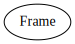

In [117]:
viz

# IoT

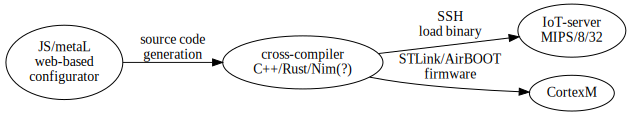

In [118]:
iot = Digraph(graph_attr={'rankdir':'LR'})
js = iot.node('js',label='JS/metaL\nweb-based\nconfigurator')
cross = iot.node('cross','cross-compiler\nC++/Rust/Nim(?)')
iot.edge('js','cross',label='source code\ngeneration')
srv = iot.node('srv','IoT-server\nMIPS/8/32')
iot.edge('cross','srv',label='SSH\nload binary')
stm = iot.node('stm',label='CortexM')
iot.edge('cross','stm',label='STLink/AirBOOT\nfirmware')
iot